No modifications detected for re-loaded extension module gtsv_batch, skipping build step...
Loading extension module gtsv_batch...
No modifications detected for re-loaded extension module implicit_fused, skipping build step...
Loading extension module implicit_fused...
NoneType: None
No modifications detected for re-loaded extension module lo_blocktridiag, skipping build step...
Loading extension module lo_blocktridiag...
NoneType: None


initiaze complete:
  solver: None
 ---- hyperparameter ----
  hyperparameter: tau_tilde=1.0
 ---- space ----
  space: nx=1000, dx=0.0010, Lx=1.0
 ---- velocity ----
  velocity: nv=200, dv=0.1005, v_max=10.0
 ---- time ----
  time: nt=101, dt=0.0005, T_total=0.05
  dtype: torch.float64
  device: cuda, GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
--- compile cuSOLVER ---
--- compile CUDA fused implicit backend ---
--- fused CUDA backend loaded ---
--- compile LO block-tridiag backend ---
--- LO block-tridiag backend loaded ---
--- Convergence Test Start ---
--- tau_tilde: 0.005 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:05<00:00, 19.01it/s]


--- PICARD ---


Progress: 100%|██████████████████████████████████████████████████████| 101/101 [00:00<00:00, 326.02it/s]


--- tau_tilde: 0.0005 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:06<00:00, 15.43it/s]


--- PICARD ---


Progress: 100%|██████████████████████████████████████████████████████| 101/101 [00:00<00:00, 133.75it/s]


--- tau_tilde: 5e-05 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:14<00:00,  6.94it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:03<00:00, 27.39it/s]


--- tau_tilde: 5e-06 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:21<00:00,  4.78it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:21<00:00,  4.60it/s]


--- Convergence Test Completed ---
ベンチマーク結果を保存: Conv_bench.pkl  (0.17 MB)
ベンチマーク結果を読み込み: Conv_bench.pkl  (meta: {'saved_at': '2025-12-01T05:34:13', 'hostname': 'arlm-ASUS-TUF-Gaming-A15-FA506QR', 'torch_version': '2.7.1+cu126', 'device': 'cuda', 'dtype': 'torch.float64', 'solver': None})
収束性テストの図を保存: Conv_bench.png
HOLO-only 図を保存: Conv_bench_holo.png
Walltime 図を保存: Conv_bench_walltime.png


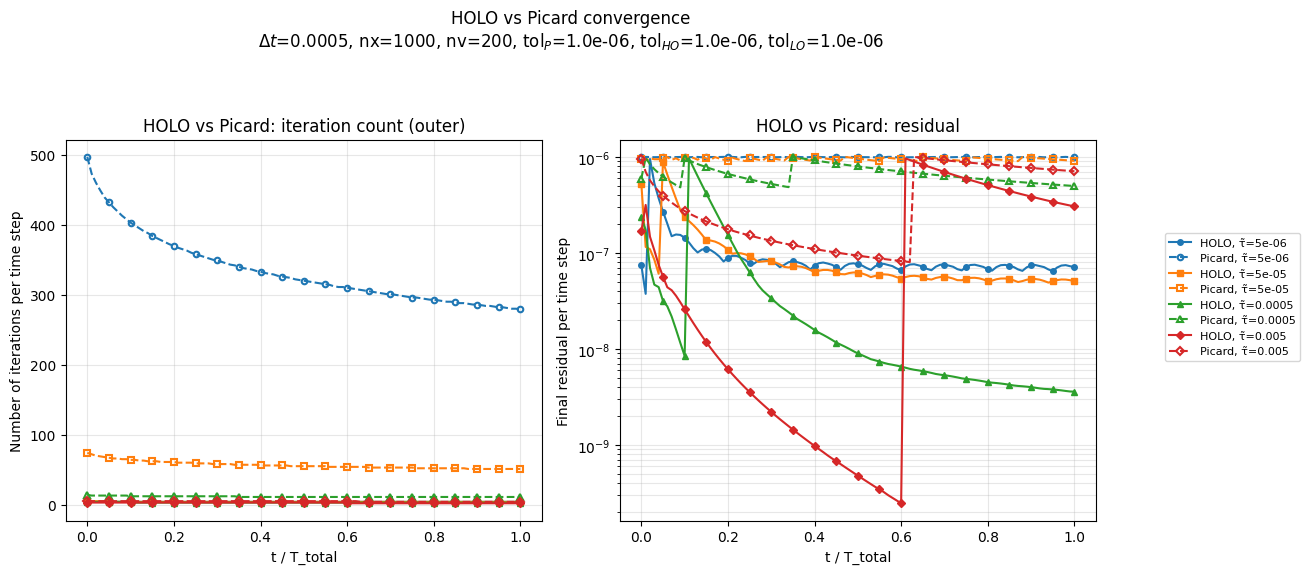

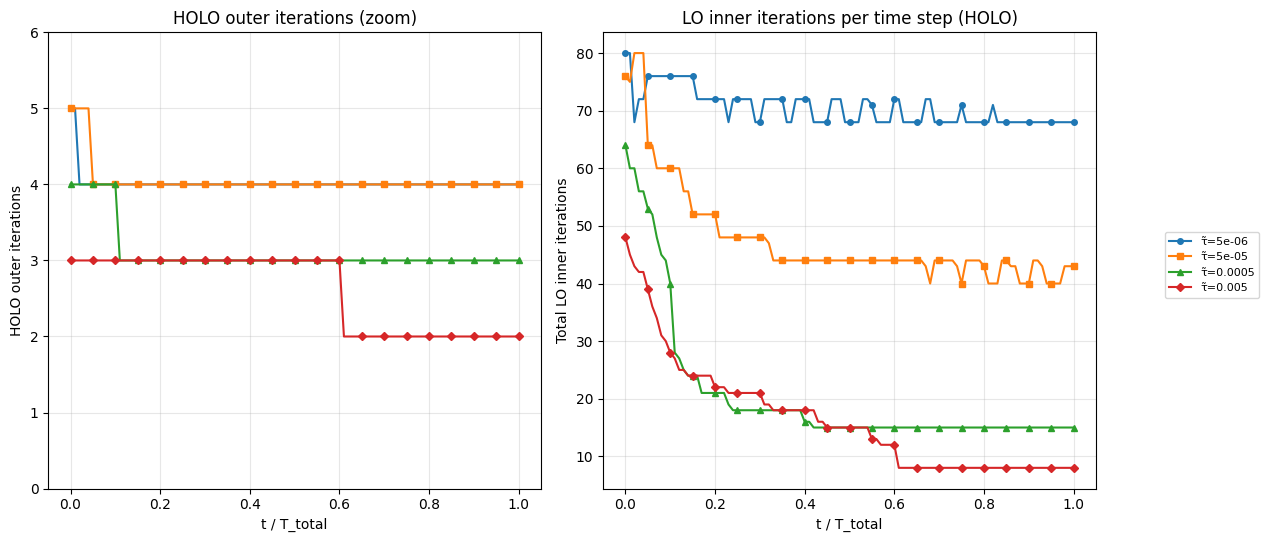

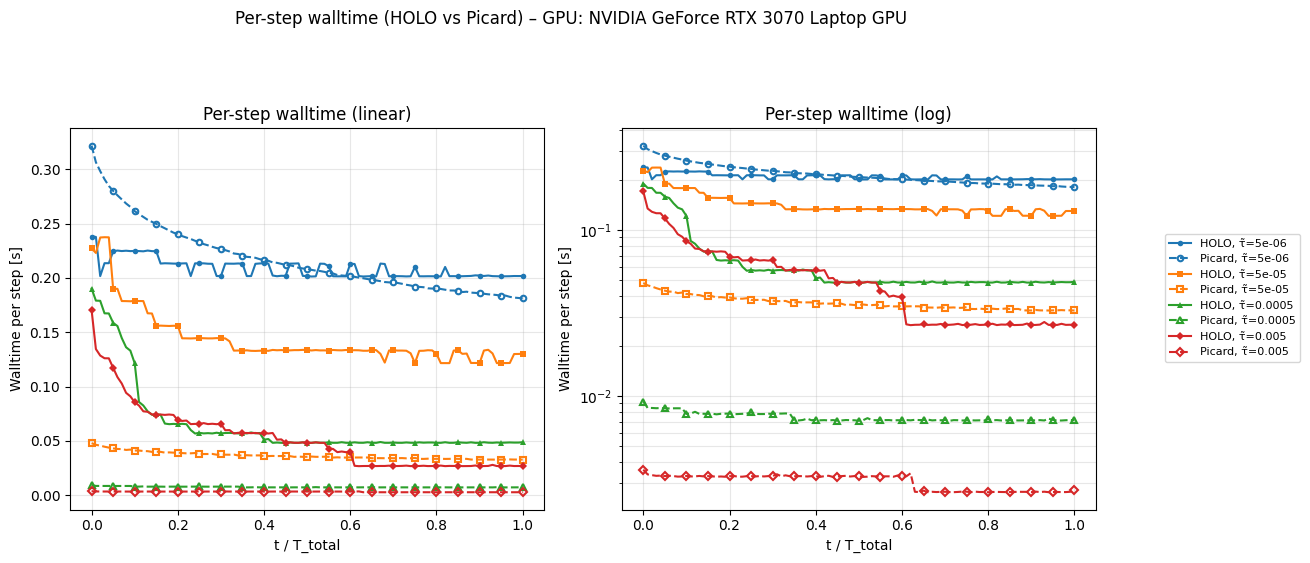

In [3]:
%run kineticEQ/tests/benchmarks/convergence_test.py

No modifications detected for re-loaded extension module gtsv_batch, skipping build step...
Loading extension module gtsv_batch...
No modifications detected for re-loaded extension module implicit_fused, skipping build step...
Loading extension module implicit_fused...
NoneType: None
No modifications detected for re-loaded extension module lo_blocktridiag, skipping build step...
Loading extension module lo_blocktridiag...
NoneType: None


initiaze complete:
  solver: None
 ---- hyperparameter ----
  hyperparameter: tau_tilde=1.0
 ---- space ----
  space: nx=500, dx=0.0020, Lx=1.0
 ---- velocity ----
  velocity: nv=200, dv=0.1005, v_max=10.0
 ---- time ----
  time: nt=101, dt=0.0005, T_total=0.05
  dtype: torch.float64
  device: cuda, GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
--- compile cuSOLVER ---
--- compile CUDA fused implicit backend ---
--- fused CUDA backend loaded ---
--- compile LO block-tridiag backend ---
--- LO block-tridiag backend loaded ---
--- Convergence Test Start ---
--- tau_tilde: 0.05 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:02<00:00, 44.14it/s]


--- PICARD ---


Progress: 100%|██████████████████████████████████████████████████████| 101/101 [00:00<00:00, 556.85it/s]


--- tau_tilde: 0.005 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:02<00:00, 39.32it/s]


--- PICARD ---


Progress: 100%|██████████████████████████████████████████████████████| 101/101 [00:00<00:00, 376.06it/s]


--- tau_tilde: 0.0005 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:03<00:00, 32.73it/s]


--- PICARD ---


Progress: 100%|██████████████████████████████████████████████████████| 101/101 [00:00<00:00, 155.73it/s]


--- tau_tilde: 5e-05 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:03<00:00, 25.80it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:03<00:00, 32.37it/s]


--- tau_tilde: 5e-06 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:04<00:00, 22.38it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.57it/s]


--- Convergence Test Completed ---
ベンチマーク結果を保存: Conv_bench.pkl  (0.21 MB)
ベンチマーク結果を読み込み: Conv_bench.pkl  (meta: {'saved_at': '2025-12-01T05:34:54', 'hostname': 'arlm-ASUS-TUF-Gaming-A15-FA506QR', 'torch_version': '2.7.1+cu126', 'device': 'cuda', 'dtype': 'torch.float64', 'solver': None})
収束性テストの図を保存: Conv_bench.png
HOLO-only 図を保存: Conv_bench_holo.png
Walltime 図を保存: Conv_bench_walltime.png


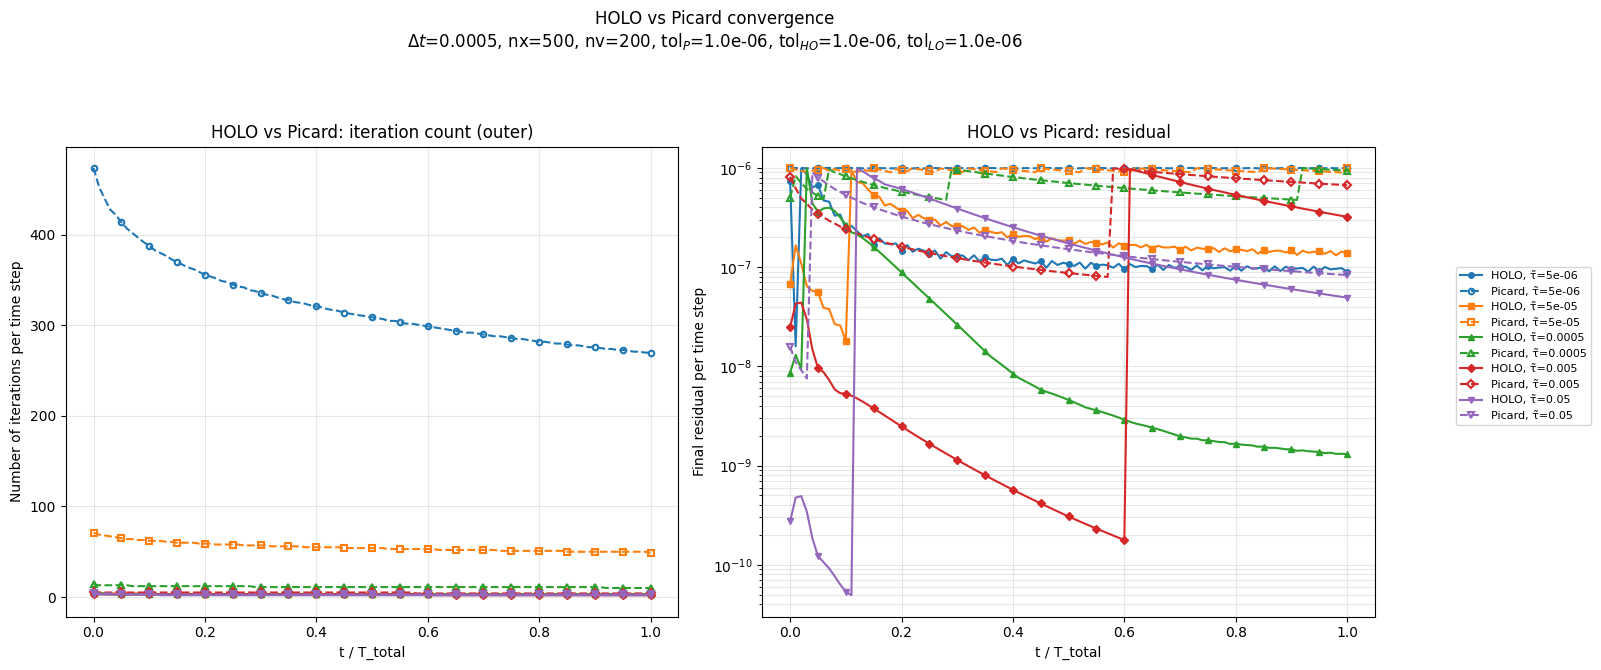

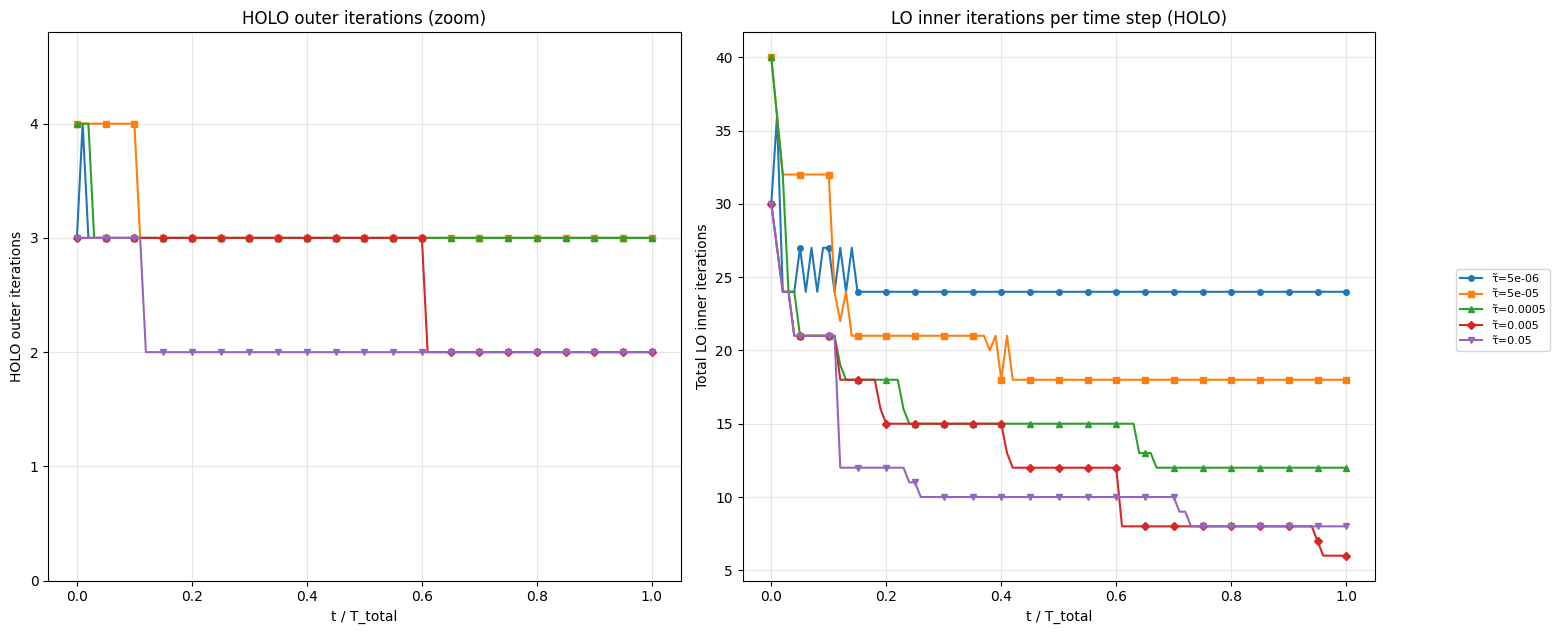

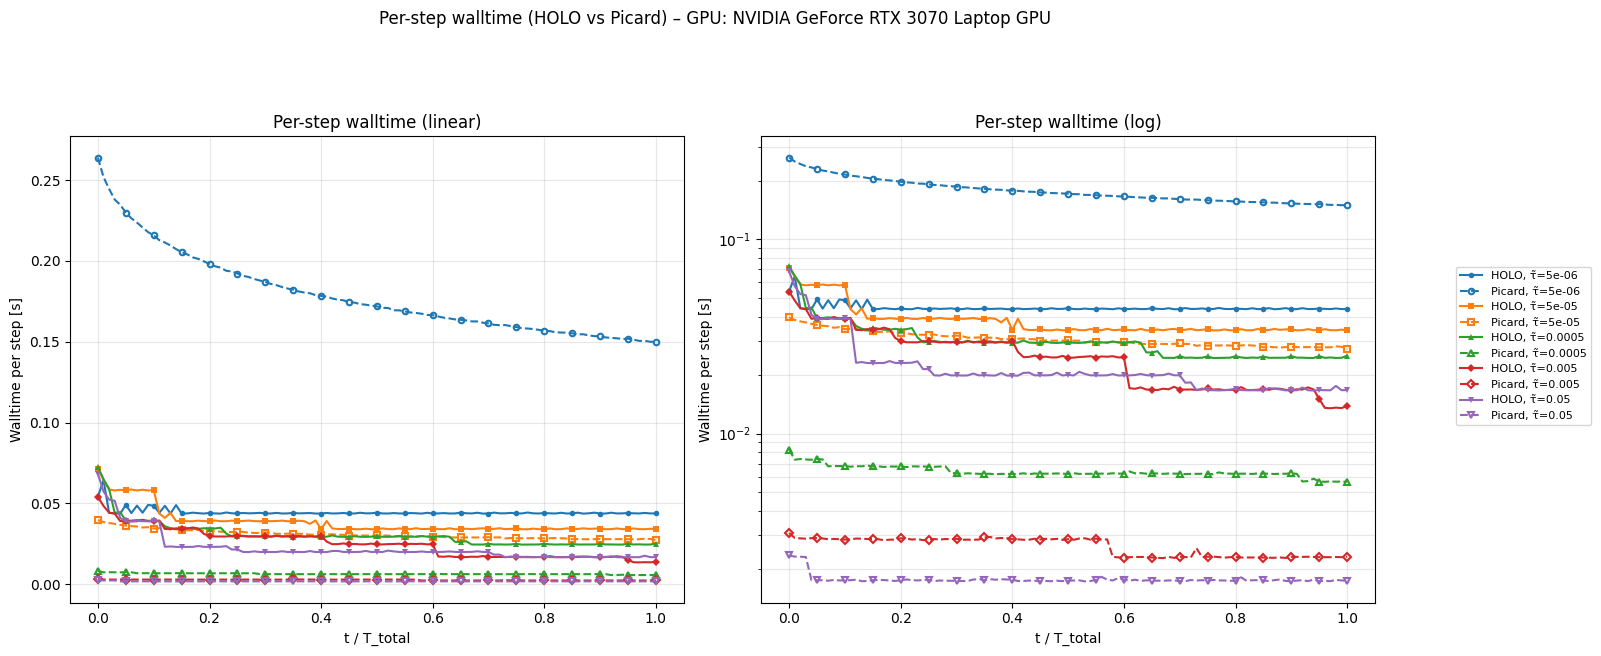

In [4]:
from kineticEQ import BGK1DPlot

no_run = False

config = {
    "v_max": 10.0,
    "dt": 5e-4,
    "nv": 200,
    "nx": 500,

    # 陰解法パラメータ
    "picard_iter": 2048,
    "picard_tol": 1e-6,

    # HOLOパラメータ
    "ho_iter": 2048,
    "lo_iter": 2048,
    "ho_tol": 1e-6,
    "lo_tol": 1e-6,

    "initial_regions": [
        {"x_range": (0.0, 0.5), "n": 1.0,   "u": 0.0, "T": 1.0},
        {"x_range": (0.5, 1.0), "n": 0.125, "u": 0.0, "T": 0.8},
    ],
    "n_left": 1.0,   "u_left": 0.0, "T_left": 1.0,
    "n_right": 0.125,"u_right": 0.0,"T_right": 0.8,
    "T_total": 0.05,
    "dtype": "float64",
    "use_tqdm": True,
    "device": "cuda",
    "auto_compile": False,
}

sim = BGK1DPlot(**config)
if not no_run:
    conv_result = sim.run_convergence_test(tau_tilde_list=[5e-2, 5e-3, 5e-4, 5e-5, 5e-6])
    sim.save_benchmark_results(
        filename=f"Conv_bench.pkl",
        bench_results=conv_result,
    )

tmp = sim.load_benchmark_results(filename=f"Conv_bench.pkl")
sim.plot_convergence_results(tmp, figsize= (15, 7), show_plots=True, filename=f"Conv_bench.png")
